<a href="https://colab.research.google.com/github/subhrajyoti-ghosh/ML-and-Deep-Learning/blob/main/Comv_AutoEcoder_Img_SR_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2023-02-19 15:38:16--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2023-02-19 15:38:16--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip.1’

DIV2K_train_HR.zip. 100%[===================>]   3.29G  98.6MB/s    in 40s     

2023-02-19 15:38:56 (84.8 MB/s) - ‘DIV2K_train_HR.zip.1’ saved [3530603713/3530603713]



In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

--2023-02-19 15:38:56--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip [following]
--2023-02-19 15:38:56--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448993893 (428M) [application/zip]
Saving to: ‘DIV2K_valid_HR.zip.1’

DIV2K_valid_HR.zip. 100%[===================>] 428.19M   102MB/s    in 4.1s    

2023-02-19 15:39:00 (104 MB/s) - ‘DIV2K_valid_HR.zip.1’ saved [448993893/448993893]



In [ ]:
from zipfile import ZipFile

In [ ]:
with ZipFile("DIV2K_train_HR.zip", 'r') as zObject:
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(path="/content/")

In [ ]:
with ZipFile("DIV2K_valid_HR.zip", 'r') as zObject:
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(path="/content/")

In [ ]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle
import os
from PIL import Image
import math
import pandas as pd

In [ ]:
images = glob.glob('/content/DIV2K_train_HR/*.png') #returns path of images
print(len(images)) #contains 800 images

800


In [ ]:
from tqdm import tqdm
from multiprocessing import Pool
progress = tqdm(total= len(images), position=0)
def read(path):
  img = tf.keras.utils.load_img(path, target_size=(256,256,3))
  img = tf.keras.utils.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img
"""p = Pool(10)
img_array = p.map(read, images)"""

  0%|          | 0/800 [00:00<?, ?it/s]

'p = Pool(10)\nimg_array = p.map(read, images)'

In [ ]:
img_array = []
for img in images:
  img_array.append(read(img))

100%|██████████| 800/800 [01:30<00:00,  9.84it/s]

In [ ]:
len(img_array)

800

In [ ]:
"""with open('img_array.pickle','wb') as f:
  pickle.dump(img_array, f)
print(len(img_array))"""

"with open('img_array.pickle','wb') as f:\n  pickle.dump(img_array, f)\nprint(len(img_array))"

In [ ]:
all_images = np.array(img_array)

In [ ]:
all_images.shape

(800, 256, 256, 3)

In [ ]:
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [ ]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image, scale_percent = 40, dw = 256, dh = 256):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  if scale_percent == 0:
    dim = (dw,dh)
  else:
    dim = (width, height)
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  if scale_percent == 0:
    dim = (dw,dh)
  else:
    print("I am here")
    width = int(small_image.shape[1] * 100 / scale_percent)
    height = int(small_image.shape[0] * 100 / scale_percent)
    dim = (width, height)
  low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA)
  return low_res_image

In [ ]:
train_x_px = []
for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:],scale_percent=0,dw=256,dh=256)
  train_x_px.append(temp)
train_x_px = np.array(train_x_px)   #Distorted images
# get low resolution images for the validation set
val_x_px = []
for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:],scale_percent=0,dw=256,dh=256)
  val_x_px.append(temp)
val_x_px = np.array(val_x_px)     #Distorted images

In [ ]:
np.array(train_x_px).shape

(640, 256, 256, 3)

In [ ]:
Input_img = Input(shape=(256, 256, 3))
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
#encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])
x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])
# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)

In [ ]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_20[0][0]']              
                                )                                                           

In [ ]:
history = autoencoder.fit(train_x_px,train_x,
            epochs=10)

Epoch 1/10
20/20 [==============================] - 19s 822ms/step - loss: 0.0426 - accuracy: 0.4975
Epoch 2/10
20/20 [==============================] - 16s 824ms/step - loss: 0.0060 - accuracy: 0.7205
Epoch 3/10
20/20 [==============================] - 17s 827ms/step - loss: 0.0022 - accuracy: 0.8075
Epoch 4/10
20/20 [==============================] - 17s 828ms/step - loss: 0.0011 - accuracy: 0.8383
Epoch 5/10
20/20 [==============================] - 17s 833ms/step - loss: 7.8106e-04 - accuracy: 0.8525
Epoch 6/10
20/20 [==============================] - 17s 837ms/step - loss: 6.3901e-04 - accuracy: 0.8618
Epoch 7/10
20/20 [==============================] - 17s 841ms/step - loss: 5.3906e-04 - accuracy: 0.8741
Epoch 8/10
20/20 [==============================] - 17s 843ms/step - loss: 4.5003e-04 - accuracy: 0.8852
Epoch 9/10
20/20 [==============================] - 17s 844ms/step - loss: 4.6663e-04 - accuracy: 0.8753
Epoch 10/10
20/20 [==============================] - 17s 844ms/step - l

In [ ]:
results = autoencoder.evaluate(val_x_px, val_x)
print('val_loss, val_accuracy', results)

5/5 [==============================] - 2s 260ms/step - loss: 3.0792e-04 - accuracy: 0.8832
val_loss, val_accuracy [0.0003079206799156964, 0.8832191228866577]


In [ ]:
type(val_x_px)

numpy.ndarray

5/5 [==============================] - 1s 245ms/step


Val :  (160, 256, 256, 3)
Pred :  (160, 256, 256, 3)
Val :  (160, 256, 256, 3)
Pred :  (160, 256, 256, 3)
Val :  (160, 256, 256, 3)
Pred :  (160, 256, 256, 3)
Val :  (160, 256, 256, 3)
Pred :  (160, 256, 256, 3)


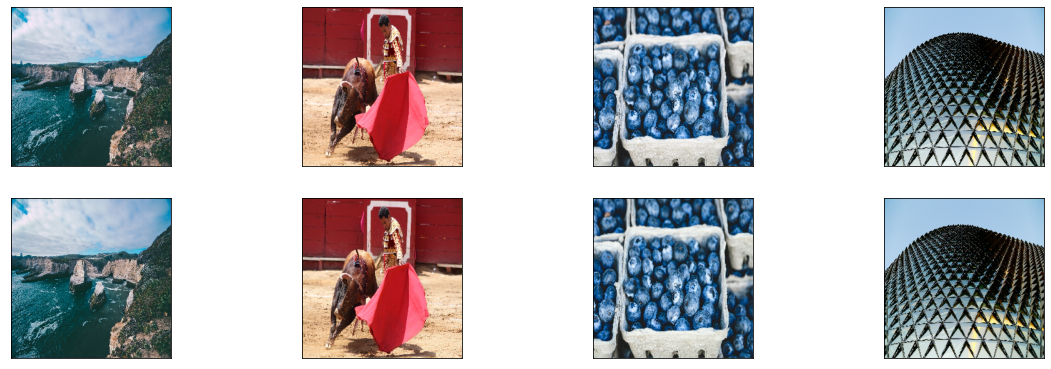

In [ ]:
predictions = autoencoder.predict(val_x_px)
n = 4
plt.figure(figsize= (20,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i+20])
  print("Val : ",val_x_px.shape)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  print("Pred : ",predictions.shape)
plt.show()

#### Shrink image for testing

In [ ]:
if os.path.exists("/content/Size_256") == False:
  os.makedirs("/content/Size_256")

In [ ]:
test_img = []

In [ ]:
for file in os.listdir("/content/DIV2K_valid_HR/"):
  img = tf.keras.utils.load_img(os.path.join("/content/DIV2K_valid_HR/",file), target_size=(256,256,3))
  #cv2.imwrite(os.path.join("/content/Size_256",file),img)
  img = tf.keras.utils.img_to_array(img)
  tf.keras.utils.save_img(os.path.join("/content/Size_256",file),img)
  img = img/255.
  test_img.append(img)

In [ ]:
arr_test_img = np.array(test_img)

In [ ]:
arr_test_img.shape

(100, 256, 256, 3)

In [ ]:
if os.path.exists("/content/Size_64") == False:
  os.makedirs("/content/Size_64")

In [ ]:
for file in os.listdir("/content/Size_256/"):
  img = tf.keras.utils.load_img(os.path.join("/content/Size_256/",file), target_size=(64,64,3))
  #cv2.imwrite(os.path.join("/content/Size_256",file),img)
  img = tf.keras.utils.img_to_array(img)
  tf.keras.utils.save_img(os.path.join("/content/Size_64",file),img)
  #img = img/255.
  #test_img.append(img)

In [ ]:
if os.path.exists("/content/Exp_256") == False:
  os.mkdir("/content/Exp_256")

In [ ]:
test_img = []

In [ ]:
for file in os.listdir("/content/Size_64"):
  img = cv2.imread(os.path.join("/content/Size_64",file))
  img = cv2.resize(img,(256,256),interpolation=cv2.INTER_AREA)
  tf.keras.utils.save_img(os.path.join("/content/Exp_256",file),img)
  img = img/255
  test_img.append(img)

In [ ]:
len(test_img)

100

In [ ]:
arr_test_img = np.array(test_img)

In [ ]:
arr_test_img.shape

(100, 256, 256, 3)

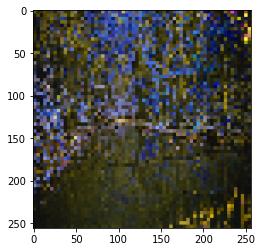

In [ ]:
plt.imshow(arr_test_img[0])

In [ ]:
pred_arr_test_img = autoencoder.predict(arr_test_img)

4/4 [==============================] - 1s 257ms/step


In [ ]:
pred_arr_test_img.shape

(100, 256, 256, 3)

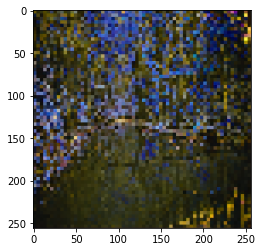

In [ ]:
plt.imshow(pred_arr_test_img[0])

In [ ]:
import shutil

In [ ]:
if os.path.exists("/content/SR_256") == False:
  os.mkdir("/content/SR_256")
else:
  shutil.rmtree('/content/SR_256')
  os.mkdir("/content/SR_256")

In [ ]:
pred_arr_test_img.shape

(100, 256, 256, 3)

In [ ]:
i = 801
for img in pred_arr_test_img:
  #print(i)
  tf.keras.utils.save_img(os.path.join("/content/SR_256","0" + str(i) + ".png"),img)
  i = i+1

In [ ]:
def find_rmse(test_img, org_img):
    cnt = 0
    tot_diff = 0
    for elem in range(len(test_img)):
        sqr_diff = (test_img[elem] - org_img[elem])**2
        tot_diff = tot_diff + sqr_diff
        
        #cnt = cnt + 1
    
    rmse = math.sqrt(tot_diff/len(test_img))
    return rmse

In [ ]:
arr_sr_img = []
arr_exp_img = []
arr_org_img = []
for file in os.listdir("/content/SR_256"):
  sr_img = cv2.imread(os.path.join("/content/SR_256",file))
  arr_sr_img.append(tf.keras.utils.img_to_array(sr_img))
  exp_img = cv2.imread(os.path.join("/content/Exp_256",file))
  #print(np.array(exp_img).shape,os.path.join("/content/Exp_256",file))
  arr_exp_img.append(tf.keras.utils.img_to_array(exp_img))
  org_img = cv2.imread(os.path.join("/content/Size_256",file))
  arr_org_img.append(tf.keras.utils.img_to_array(org_img))

In [ ]:
arr_sr_img = np.array(arr_sr_img)
arr_exp_img = np.array(arr_exp_img)
arr_org_img = np.array(arr_org_img)

In [ ]:
arr_sr_img.shape

(100, 256, 256, 3)

In [ ]:
df_perf = pd.DataFrame(columns=["Test_Img","Exp_Img","Org_Img","RMSE_Test_vs_Org","RMSE_Exp_vs_Org"])

In [ ]:
#print(arr_sr_img_1d.shape,arr_exp_img_1d.shape,arr_org_img_1d.shape)

for i in range(0,100):
  arr_sr_img_1d = arr_sr_img[i].ravel()
  arr_exp_img_1d = arr_exp_img[i].ravel()
  arr_org_img_1d = arr_org_img[i].ravel()
  
  RMSE_Test_vs_Org = 0
  RMSE_Exp_vs_Org = 0
  
  RMSE_Test_vs_Org= find_rmse(arr_org_img_1d,arr_sr_img_1d)
  RMSE_Exp_vs_Org= find_rmse(arr_org_img_1d,arr_exp_img_1d)
  
  df_perf = pd.concat([df_perf,pd.DataFrame(
      {
       "Test_Img" : i
       ,"Exp_Img" : i
       ,"Org_Img" : i
       ,"RMSE_Test_vs_Org" : [RMSE_Test_vs_Org]
       ,"RMSE_Exp_vs_Org" : [RMSE_Exp_vs_Org]
       }
       )
  ]
  )


In [ ]:
df_perf

,Test_Img,Exp_Img,Org_Img,RMSE_Test_vs_Org,RMSE_Exp_vs_Org
0,0,0,0,58.666270,48.156412
0,1,1,1,114.016980,44.421225
0,2,2,2,92.279823,47.977659
0,3,3,3,81.420291,55.905782
0,4,4,4,71.849824,63.056243
...,...,...,...,...,...
0,95,95,95,87.916695,60.255298
0,96,96,96,115.213800,51.018164
0,97,97,97,117.975689,62.032026
0,98,98,98,98.767615,52.290738


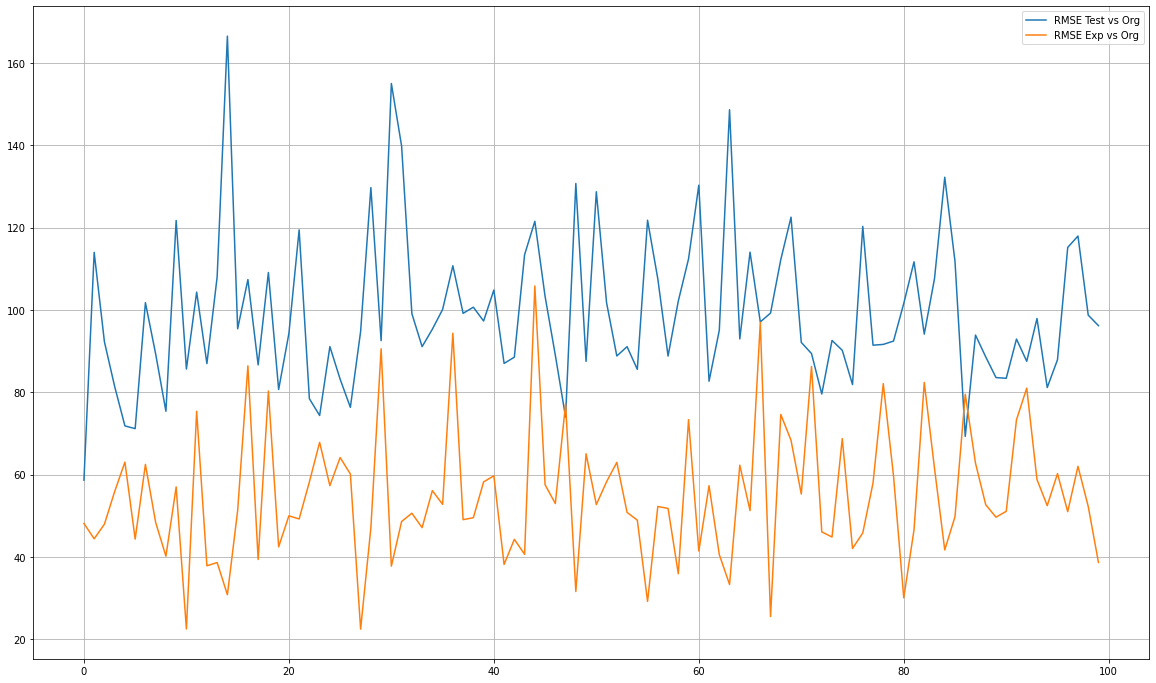

In [ ]:
plt.figure(figsize=(20, 12))
plt.plot(df_perf["Test_Img"],df_perf["RMSE_Test_vs_Org"],label="RMSE Test vs Org")
plt.plot(df_perf["Test_Img"],df_perf["RMSE_Exp_vs_Org"],label="RMSE Exp vs Org")
plt.grid()
plt.legend()
plt.show()

# Convolutional Autoencoder using Convolutional Transpose

In [ ]:
Input_img = Input(shape=(256, 256, 3))
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded_v2 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
#print(encoded_v2.shape,x5.shape)
#encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
# decoding architecture
x7 = Conv2DTranspose(1,(2,2),strides=(2,2))(encoded_v2)
#print(x7.shape)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])
x11 = Conv2DTranspose(64,(2,2),strides=(2,2))(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
#print(x2.shape,x13.shape)
x14 = Add()([x2, x13])
# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
autoencoder_v2 = Model(Input_img, decoded)
autoencoder_v2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
autoencoder_v2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_30[0][0]']              
                                )                                                           

In [ ]:
autoencoder_v2.compile()

In [ ]:
history_v2 = autoencoder_v2.fit(train_x_px,train_x,epochs=10)

Epoch 1/10


20/20 [==============================] - 2s 18ms/step - loss: 2.0039e-05
Epoch 2/10
20/20 [==============================] - 0s 14ms/step - loss: 2.0039e-05
Epoch 3/10
20/20 [==============================] - 0s 14ms/step - loss: 2.0039e-05
Epoch 4/10
20/20 [==============================] - 0s 16ms/step - loss: 2.0039e-05
Epoch 5/10
20/20 [==============================] - 0s 14ms/step - loss: 2.0038e-05
Epoch 6/10
20/20 [==============================] - 0s 14ms/step - loss: 2.0038e-05
Epoch 7/10
20/20 [==============================] - 0s 16ms/step - loss: 2.0038e-05
Epoch 8/10
20/20 [==============================] - 0s 15ms/step - loss: 2.0038e-05
Epoch 9/10
20/20 [==============================] - 0s 18ms/step - loss: 2.0038e-05
Epoch 10/10
20/20 [==============================] - 0s 20ms/step - loss: 2.0038e-05


In [ ]:
results_v2 = autoencoder_v2.evaluate(val_x_px, val_x)
print('val_loss, val_accuracy', results_v2)

5/5 [==============================] - 0s 11ms/step - loss: 2.0038e-05
val_loss, val_accuracy 2.003818008233793e-05


5/5 [==============================] - 1s 205ms/step
Val :  (160, 256, 256, 3)
Pred :  (160, 256, 256, 3)
Val :  (160, 256, 256, 3)
Pred :  (160, 256, 256, 3)
Val :  (160, 256, 256, 3)
Pred :  (160, 256, 256, 3)
Val :  (160, 256, 256, 3)
Pred :  (160, 256, 256, 3)


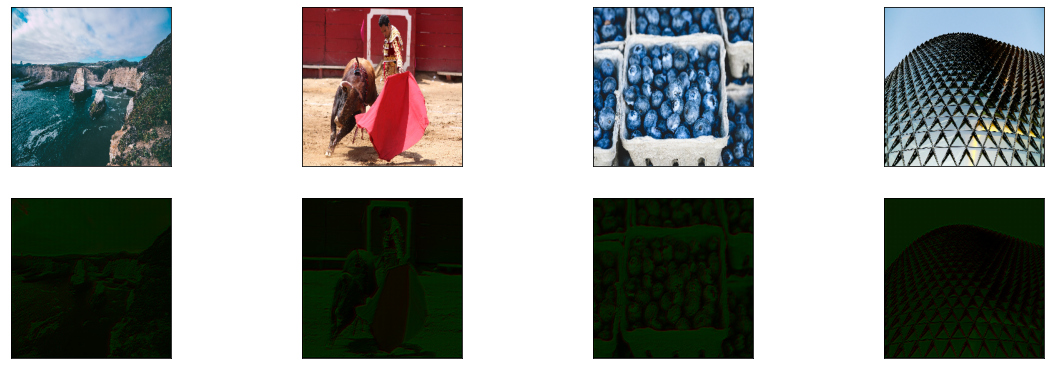

In [ ]:
predictions_v2 = autoencoder_v2.predict(val_x_px)
n = 4
plt.figure(figsize= (20,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i+20])
  print("Val : ",val_x_px.shape)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions_v2[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  print("Pred : ",predictions_v2.shape)
plt.show()

## Shrink image for testing with autoencoder_v2

In [ ]:
if os.path.exists("/content/Size_256_v2") == False:
  os.makedirs("/content/Size_256_v2")

In [ ]:
test_img_v2 = []

In [ ]:
for file in os.listdir("/content/DIV2K_valid_HR/"):
  img = tf.keras.utils.load_img(os.path.join("/content/DIV2K_valid_HR/",file), target_size=(256,256,3))
  #cv2.imwrite(os.path.join("/content/Size_256",file),img)
  img = tf.keras.utils.img_to_array(img)
  tf.keras.utils.save_img(os.path.join("/content/Size_256_v2",file),img)
  img = img/255.
  test_img_v2.append(img)

In [ ]:
arr_test_img_v2 = np.array(test_img_v2)

In [ ]:
arr_test_img_v2.shape

(100, 256, 256, 3)

In [ ]:
if os.path.exists("/content/Size_64_v2") == False:
  os.makedirs("/content/Size_64_v2")

In [ ]:
for file in os.listdir("/content/Size_256_v2/"):
  img = tf.keras.utils.load_img(os.path.join("/content/Size_256_v2/",file), target_size=(64,64,3))
  #cv2.imwrite(os.path.join("/content/Size_256",file),img)
  img = tf.keras.utils.img_to_array(img)
  tf.keras.utils.save_img(os.path.join("/content/Size_64_v2",file),img)
  #img = img/255.
  #test_img.append(img)

In [ ]:
if os.path.exists("/content/Exp_256_v2") == False:
  os.mkdir("/content/Exp_256_v2")

In [ ]:
test_img_v2 = []

In [ ]:
for file in os.listdir("/content/Size_64_v2"):
  img = cv2.imread(os.path.join("/content/Size_64_v2",file))
  img = cv2.resize(img,(256,256),interpolation=cv2.INTER_AREA)
  tf.keras.utils.save_img(os.path.join("/content/Exp_256_v2",file),img)
  img = img/255
  test_img_v2.append(img)

In [ ]:
arr_test_img_v2 = np.array(test_img_v2)

In [ ]:
arr_test_img_v2.shape

(100, 256, 256, 3)

In [ ]:
pred_arr_test_img_v2 = autoencoder_v2.predict(arr_test_img_v2)

4/4 [==============================] - 1s 275ms/step


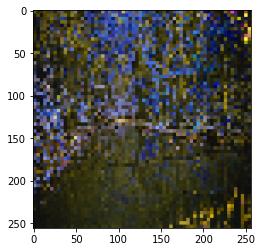

In [ ]:
plt.imshow(arr_test_img_v2[0])

In [ ]:
if os.path.exists("/content/SR_256_v2") == False:
  os.mkdir("/content/SR_256_v2")
else:
  shutil.rmtree('/content/SR_256_v2')
  os.mkdir("/content/SR_256_v2")

In [ ]:
i = 801
for img in pred_arr_test_img_v2:
  #print(i)
  tf.keras.utils.save_img(os.path.join("/content/SR_256_v2","0" + str(i) + ".png"),img)
  i = i+1

In [ ]:
arr_sr_img_v2 = []
arr_exp_img_v2 = []
arr_org_img_v2 = []
for file in os.listdir("/content/SR_256_v2"):
  sr_img_v2 = cv2.imread(os.path.join("/content/SR_256_v2",file))
  arr_sr_img_v2.append(tf.keras.utils.img_to_array(sr_img_v2))
  exp_img_v2 = cv2.imread(os.path.join("/content/Exp_256_v2",file))
  #print(np.array(exp_img).shape,os.path.join("/content/Exp_256",file))
  arr_exp_img_v2.append(tf.keras.utils.img_to_array(exp_img_v2))
  org_img_v2 = cv2.imread(os.path.join("/content/Size_256_v2",file))
  arr_org_img_v2.append(tf.keras.utils.img_to_array(org_img_v2))

In [ ]:
arr_sr_img_v2 = np.array(arr_sr_img_v2)
arr_exp_img_v2 = np.array(arr_exp_img_v2)
arr_org_img_v2 = np.array(arr_org_img_v2)

In [ ]:
df_perf_v2 = pd.DataFrame(columns=["Test_Img","Exp_Img","Org_Img","RMSE_Test_vs_Org","RMSE_Exp_vs_Org"])

In [ ]:
#print(arr_sr_img_1d.shape,arr_exp_img_1d.shape,arr_org_img_1d.shape)

for i in range(0,100):
  arr_sr_img_1d = arr_sr_img_v2[i].ravel()
  arr_exp_img_1d = arr_exp_img_v2[i].ravel()
  arr_org_img_1d = arr_org_img_v2[i].ravel()
  
  RMSE_Test_vs_Org = 0
  RMSE_Exp_vs_Org = 0
  
  RMSE_Test_vs_Org= find_rmse(arr_org_img_1d,arr_sr_img_1d)
  RMSE_Exp_vs_Org= find_rmse(arr_org_img_1d,arr_exp_img_1d)
  
  df_perf_v2 = pd.concat([df_perf_v2,pd.DataFrame(
      {
       "Test_Img" : i
       ,"Exp_Img" : i
       ,"Org_Img" : i
       ,"RMSE_Test_vs_Org" : [RMSE_Test_vs_Org]
       ,"RMSE_Exp_vs_Org" : [RMSE_Exp_vs_Org]
       }
       )
  ]
  )


In [ ]:
df_perf_v2

,Test_Img,Exp_Img,Org_Img,RMSE_Test_vs_Org,RMSE_Exp_vs_Org
0,0,0,0,61.226836,48.156412
0,1,1,1,122.424063,44.421225
0,2,2,2,121.138299,47.977659
0,3,3,3,84.610279,55.905782
0,4,4,4,81.366941,63.056243
...,...,...,...,...,...
0,95,95,95,83.058504,60.255298
0,96,96,96,88.438205,51.018164
0,97,97,97,133.229925,62.032026
0,98,98,98,84.147643,52.290738


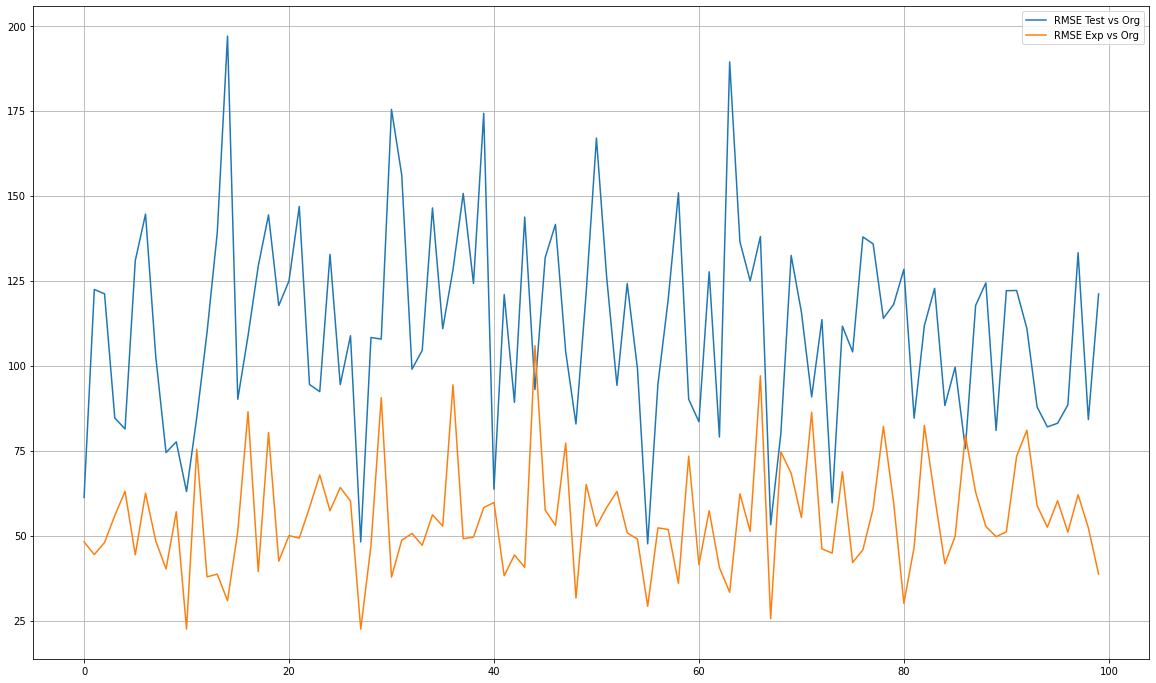

In [ ]:
plt.figure(figsize=(20, 12))
plt.plot(df_perf_v2["Test_Img"],df_perf_v2["RMSE_Test_vs_Org"],label="RMSE Test vs Org")
plt.plot(df_perf_v2["Test_Img"],df_perf_v2["RMSE_Exp_vs_Org"],label="RMSE Exp vs Org")
plt.grid()
plt.legend()
plt.show()